# Model Training

In this notebook the *Dutch Dyslexia Programme (DDP)* and *ePodium* datasets are used to train a **deep neural network model**.

The model is trained to predict the age and risk of dyslexia from brain signals. This input data consists of the average of multiple epochs of the EEG data, called an *Event Related Potential* (ERP).

+ In section 1. [Prepare Dataset](#1mt) ...
+ In section 2. [Deep Learning](#2mt) ...

It is recommended to run this notebook with CUDA enabled with a dedicated graphics card to speed-up the training.

#### Import Packages

In [1]:
import numpy as np
import os

# Local
import local_paths
from functions import processing, display_helper, data_io
from functions.epodium import Epodium
from functions.ddp import DDP
from functions.train_and_predict import EpodiumSequence, DDPSequence

# Models
from models.dl_4_tsc import encoder_model, fully_convolutional_model, resnet_model
from models.eeg_dl import transformer_model

# Tensorflow dependencies
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, MeanSquaredError
from keras.metrics import Precision, BinaryAccuracy, Recall
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

<br>



---
<a id='1mt'></a>
## 1. Prepare Dataset

This notebook works with both the ePodium and the DDP dataset. Choose which dataset to use by changing *dataset_name*.

In [2]:
# Choose between datasets: "epodium" "ddp"
dataset_name = "ddp"

if dataset_name == "epodium":
    dataset = Epodium()    
    epochs_directory = local_paths.ePod_epochs
    event_directory = local_paths.ePod_epochs_events
    
    epod_labels = dataset.create_labels(local_paths.ePod_metadata)
    print(f"The available labels are:\n {list(epod_labels.columns)}")

elif dataset_name == "ddp":
    dataset = DDP()
    epochs_directory = local_paths.DDP_epochs
    event_directory = local_paths.DDP_epochs_events
    
    directory_age_metadata = os.path.join(local_paths.DDP_metadata, "ages")
    ddp_labels = dataset.create_labels(local_paths.DDP_dataset, directory_age_metadata)
    print(f"The available labels are:\n {list(ddp_labels.columns)}") 

The available labels are:
 ['filename', 'participant', 'age_group', 'age_days']


#### Split processed epochs* into train and test sequence.


First choose which processed data to use


    *In the context of electroencephalography (EEG), epochs are EEG segments in which an event occurs. In the context of deep learning, epochs are iterations over the entire training dataset. We now use epochs in the deep learning context.

In [3]:
experiment_list = processing.valid_experiments(dataset, event_directory, min_standards=180, min_deviants=80)

if dataset_name == "ddp":
    experiment_list = list(set(experiment_list)-set(dataset.wrong_channels_experiments))
    print(f"{len(dataset.wrong_channels_experiments)} experiments have incorrect channels. "
          f"{len(experiment_list)} experiments remain")

# train / test / validation ratio
r = np.array([0.7, 0.15, 0.15])
experiments_train_val, experiments_test = dataset.split_dataset(experiment_list, (r[0]+r[2])/r.sum())
experiments_train, experiments_val = dataset.split_dataset(experiments_train_val, r[0]/(r[0]+r[2]))

print(f"\nThe dataset is split up into {len(experiments_train)} train, "
      f"{len(experiments_test)} test, and {len(experiments_val)} validation experiments")

Analyzed: 1057 bad: 238
819 experiments have enough epochs for analysis.
109 experiments have incorrect channels. 710 experiments remain

The dataset is split up into 506 train, 94 test, and 110 validation experiments


#### Preparing data iterator (Sequence) as input to the deep learning models.
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

TODO explanation on noise + other variables / difference in train/test/val

In [4]:
if dataset_name == "epodium":
    train_sequence = EpodiumSequence(experiments_train, epod_labels, epochs_directory, n_experiments_batch=4, gaussian_noise=1e-6)
    test_sequence = EpodiumSequence(experiments_test, epod_labels, epochs_directory, n_experiments_batch=4)
    val_sequence = EpodiumSequence(experiments_val, epod_labels, epochs_directory, n_experiments_batch=4)
    
if dataset_name == "ddp":
    train_sequence = DDPSequence(experiments_train, ddp_labels, epochs_directory, n_experiments_batch=8, n_instances_per_experiment=4, gaussian_noise=1e-6)
    test_sequence = DDPSequence(experiments_test, ddp_labels, epochs_directory, n_experiments_batch=8, n_instances_per_experiment=4)
    val_sequence = DDPSequence(experiments_val, ddp_labels, epochs_directory, n_experiments_batch=8, n_instances_per_experiment=4)

#### Visualise data instance

During processing, the epochs are chosen to be 1 second in which the event occurs at 0.2s.

Loading experiment 407_29
The shape of one data instance is (26, 501)


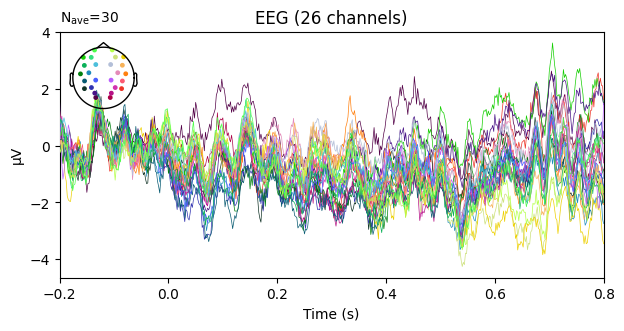

In this experiment the age of the participant is 877 days.
Beware, the absolute value of the y-axis is meaningless due to data normalization. Each data-point is divided by the standard deviation of all the signals.


In [5]:
random_participant_index = 0

temp_sequence = DDPSequence(experiments_train, ddp_labels, 
                            epochs_directory, 
                            gaussian_noise=1e-6, 
                            n_trials_averaged=30, 
                            n_experiments_batch=1, 
                            n_instances_per_experiment=1)

x, y = temp_sequence.__getitem__(random_participant_index, True)

print(f"The shape of one data instance is {x[0].shape}")
display_helper.plot_array_as_evoked(x[0]*1e-6, dataset.channels_epod_ddp, frequency=500, n_trials=30)
print(f"In this experiment the age of the participant is {int(y[0])} days.")
print("Beware, the absolute value of the y-axis is meaningless due to data normalization. "
      "Each data-point is divided by the standard deviation of all the signals.")

<br>
<br>

---
<a id='2mt'></a>
## 2. Deep Learning

Choose model: choose between encoder, transformer, ()

In [9]:
model_name = "ddp_resnet_age_26ch_500hz"

# Model dimensions
n_channels = 26
n_timesteps = 501
x_dimension = (n_channels, n_timesteps)
y_dimension = 1
# model = encoder_model(x_dimension, y_dimension)
# model = transformer_model(x_dimension, y_dimension)
model = resnet_model(x_dimension, y_dimension)

#### Train model

__input dimensions__: 
+ x (batches, timesteps, channels)
+ y (batches, labels)

__labels__: 
+ Binary: At risk of dyslexia
+ Regressive: Age, Vocabulary

In [10]:
# Hyperparameters
epochs = 100
learning_rate = 1e-3

# Paths for saving model data
base_dir = os.path.join(local_paths.models, model_name)
model_dir = os.path.join(base_dir, "model")
subsets_dir = os.path.join(base_dir, "subsets")
path_history = os.path.join(base_dir, "history.npy")
path_weights = os.path.join(base_dir, "weights.h5")

if os.path.exists(model_dir):
    print(f"Model: '{model_name}' already exist. Delete the existing model first or rename this model.")    
else:
    print(f"Create model: {model_name}")
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
    if not os.path.exists(subsets_dir):
        os.mkdir(subsets_dir)

    # Save train / test / validation sets for future testing
    data_io.save_experiment_names(experiments_train, os.path.join(subsets_dir, "train_set.txt"))
    data_io.save_experiment_names(experiments_test, os.path.join(subsets_dir, "test_set.txt"))
    data_io.save_experiment_names(experiments_val, os.path.join(subsets_dir, "validation_set.txt"))

    # Model configurations
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError()) # , metrics=[Precision(), BinaryAccuracy(), Recall()]
    checkpointer = ModelCheckpoint(filepath=path_weights, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, factor=0.9, verbose=1)
    
    # Fit model
    history = model.fit(x=train_sequence, validation_data=val_sequence, epochs=epochs, callbacks=[checkpointer, reduce_lr])
    
    # Save model and training history
    model.save(model_dir)
    np.save(path_history, history.history)

Create model: ddp_resnet_age_26ch_500hz
Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 695140.9375 
Epoch 1: val_loss improved from inf to 693103.00000, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_resnet_age_26ch_500hz/weights.h5
64/64 [==============================] - 917s 14s/step - loss: 695140.9375 - val_loss: 693103.0000 - lr: 0.0010
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 681192.6875
Epoch 2: val_loss improved from 693103.00000 to 685831.12500, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_resnet_age_26ch_500hz/weights.h5
64/64 [==============================] - 717s 11s/step - loss: 681192.6875 - val_loss: 685831.1250 - lr: 0.0010
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 664144.6875 
Epoch 3: val_loss improved from 685831.12500 to 664142.00000, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_resnet_age_26c

INFO:tensorflow:Assets written to: /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_resnet_age_26ch_500hz/model/assets


INFO:tensorflow:Assets written to: /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_resnet_age_26ch_500hz/model/assets


#### Show Training History

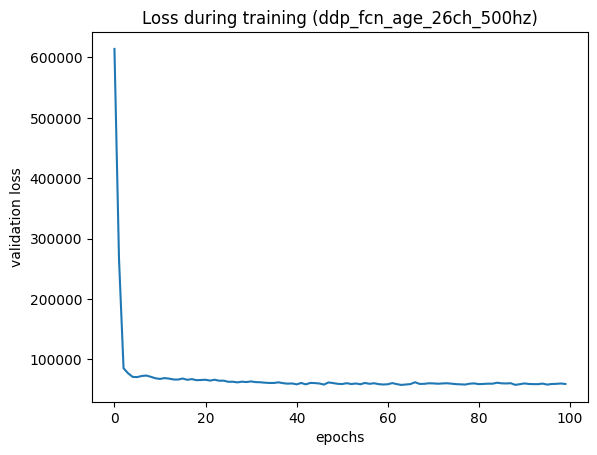

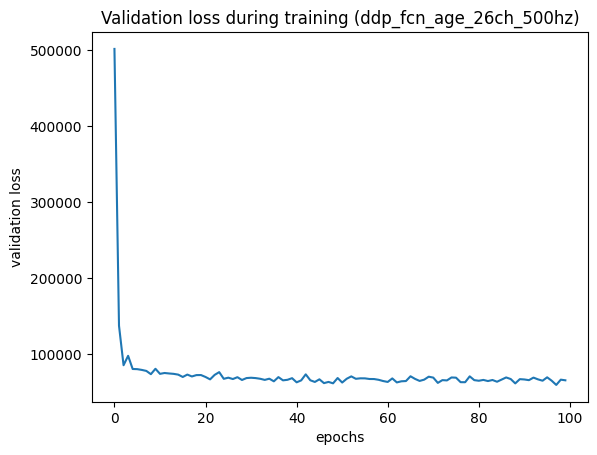

In [8]:
display_helper.show_plot(x=range(len(history.history['loss'])), y=history.history['loss'], xlabel="epochs", ylabel="validation loss", title=f"Loss during training ({model_name})")
display_helper.show_plot(x=range(len(history.history['loss'])), y=history.history['val_loss'], xlabel="epochs", ylabel="validation loss", title=f"Validation loss during training ({model_name})")